# Comparing two samples using `stambo`

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Oulu-IMEDS/stambo/main?labpath=notebooks%2FTwo_sample_test.ipynb)

V1.1.4: © Aleksei Tiulpin, PhD, 2025

There are many cases, when we develop models other than classification or regression, and we want to compute scores per datapoint, and then find their mean. We may often want to compare just two samples of measurements, and `stambo` allows to do this easily too.

This example shows how to conduct a simple two-sample test. The example is synthetic, and we will just simply generate two Gaussian samples, and assess whether the mean of the second sample is greater than the mean of the first sample.

## Importing the libraries

In [1]:
import numpy as np
import stambo
import matplotlib.pyplot as plt

SEED=2025

In [2]:
stambo.__version__

'0.1.4'

## Data generation

In [3]:
np.random.seed(SEED)
n_samples = 50
sample_1 = np.random.randn(n_samples)
sample_2 = np.random.randn(n_samples)+0.7 # effect size is 0.7

## Sample comparison

Note that when it comes to a two-sample test, `stambo` does not require the statistic of choice to be a machine learning metric that is a subclass of `stambo.metrics.Metric`.
Note that we have a non-paired design here (a regular two-sample test), so, it needs to be specified.

In [4]:
res = stambo.two_sample_test(sample_1, sample_2, statistics={"Mean": lambda x: x.mean()}, non_paired=True)

Bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 55337.91it/s]


In [5]:
res

{'Mean': array([ 0.18418158,  0.23771615, -0.12154188,  0.58512178,  0.08127468,
        -0.16881557,  0.33611198,  0.31899082,  0.0732373 ,  0.56617054])}

## LaTeX report

In [6]:
print(stambo.to_latex(res, m1_name="Control", m2_name="Treated"))

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Sample 1 & $0.08$ [$-0.17$-$0.34$] \\ 
Sample 2 & $0.32$ [$0.07$-$0.57$] \\ 
\midrule
Effect size & $0.24$ [$-0.12$-$0.59]$ \\ 
\midrule
$p$-value & $0.18$ \\ 
\bottomrule
\end{tabular}


This example shows that for the data at hand we did not have samples to reject the null. 

## Grouped data

A very common scenario we should consider is when data is grouped. For example, we have multiple datapoints from the same subjects. 

Below is the simulation code that generates synthetic data for case when we have multiple datapoints from the same subject. To see if your data is grouped, you can plot a covaraince matrix of your data. 

Here, we sample from a distribution of estimators of the covariance matrices to reveal the block structure. 
Here's a breakdown of the sampling process:
- `M`: Total number of subjects in the study.
- `N`: Total number of measurements across all subjects.
- `dim`: Dimensionality of each measurement (e.g., if measurements are scalar, dim=1).
- `mean_range`: The range from which each subject's mean measurement value is randomly sampled.
- `base_cov`: A covariance matrix that defines how measurements within the same subject may vary around the subject's mean.

The process of data simulation involves:
1. Generating a specified number of measurements for each subject using a multinomial distribution, ensuring each subject has at least one measurement
2. Simulating the actual measurements for each subject based on their unique mean and a structured covariance matrix. This is repeated 1000 times to average out random fluctuations and get a stable estimate of the covariance structure across subjects.

In [9]:
# Example usage
M = 10  # Number of subjects
N = 100  # Total measurements
dim = 1  # Dimensionality of each measurement

mean_range = np.array((-5, 0))  # Each subject's mean is sampled from this range
base_cov = np.ones((dim, dim))  # Example structured covariance

res = 0
np.random.seed(SEED)
n_measurements_per_subj = stambo.synthetic.generate_n_measurements(M, N, random=True, d_temp=2)

# How many times to regenerate the dataset
n_samples_cov = 1000
for i in range(n_samples_cov):
    data, subject_ids, means = stambo.synthetic.generate_subject_measurements(n_measurements_per_subj, mean_range, base_cov)
    res += data @ data.T 

res /= n_samples_cov

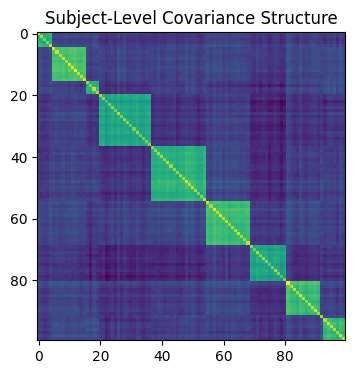

Data for subject 0: 5
Data for subject 1: 11
Data for subject 2: 4
Data for subject 3: 17
Data for subject 4: 18
Data for subject 5: 14
Data for subject 6: 12
Data for subject 7: 11
Data for subject 8: 1
Data for subject 9: 7


In [10]:
plt.figure(figsize=(4, 4))
plt.imshow(res)
plt.title("Subject-Level Covariance Structure")
plt.show()

for s_id in range(M):
    n_per_i = data[subject_ids == s_id].shape[0]
    print(f"Data for subject {s_id}: {n_per_i}")

## Grouped data & paired design

Let us now cover another common case: we have a number of subjects with multiple measurements taken before and after treatment. We want to estimat the treatment effect.
This case is highly related to comparing two models. Model 1 could be seen as control, and improvements done on it (Model 2) could be seen as treatment. 

Here, we have developed functionality to generate data from a paired design. We can easily use stamo's API to specify groups. 

In [12]:
paired_data, s_ids_paired = stambo.synthetic.generate_paired_data(n_subjects=3, n_measurements=40, effect_size=0.5, dim=1, mean_range=(0, 0.5), seed=SEED)

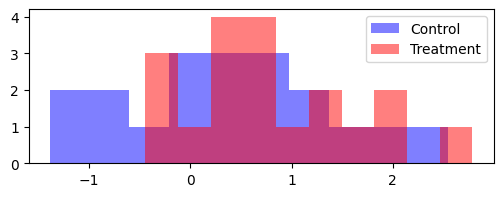

In [15]:
plt.figure(figsize=(6, 2))
plt.hist(paired_data[:, 0], label="Control", color="blue", alpha=0.5)
plt.hist(paired_data[:, 1], label="Treatment", color="red", alpha=0.5)
plt.legend()
plt.show()


Let us now first run the test without specifying the groups. 

In [16]:
res = stambo.two_sample_test(paired_data[:, 0], paired_data[:, 1], statistics={"Mean": lambda x: x.mean()}, seed=SEED)
print(stambo.to_latex(res, m1_name="Control", m2_name="Treatment"))

Bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 56692.27it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Control & $0.36$ [$-0.10$-$0.83$] \\ 
Treatment & $0.82$ [$0.46$-$1.21$] \\ 
\midrule
Effect size & $0.46$ [$-0.07$-$1.00]$ \\ 
\midrule
$p$-value & $0.09$ \\ 
\bottomrule
\end{tabular}


What we can se above, is that the test does not detect an effect and the 95% on the effect size are very wide.

In [17]:
res = stambo.two_sample_test(paired_data[:, 0], paired_data[:, 1], statistics={"Mean": lambda x: x.mean()}, groups=s_ids_paired, seed=SEED)
# Let us add more digits to see the p-value clearer
print(stambo.to_latex(res, m1_name="Control", m2_name="Treatment", n_digits=4))

Bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 53286.45it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{ll} \\ 
\toprule 
\textbf{Model} & \textbf{Mean} \\ 
\midrule 
Control & $0.3640$ [$0.2471$-$0.5008$] \\ 
Treatment & $0.8246$ [$0.7465$-$0.9272$] \\ 
\midrule
Effect size & $0.4607$ [$0.3419$-$0.5721]$ \\ 
\midrule
$p$-value & $0.0002$ \\ 
\bottomrule
\end{tabular}


Once we have specified the groups, we get very tight 95% CIs around the true effect (0.5), showing that it is really positive. Moreover, we are able to reject the null, since our bootstrap procedure closely resembles the data generating process. 